# SciML SANUM2024
# Lab 3: Reverse-mode automatic differentiation and Zygote.jl

When the number of unknowns becomes large forward-mode automatic differentiation as
implemented in ForwardDiff.jl becomes prohibitively expensive for computing gradients and instead we need to
use reverse-mode automatic differentiation: this is best thought of as implementing the chain-rule
in an automatic fashion, with a specific choice of multiplying the underlying Jacobians.

Computing gradients is important for solving optimisation problems, which is what ultimately what training a neural network
is. Therefore we also look at solving some
simple optimissation problems, using Optimsation.jl

**Learning Outcomes**

1. Computing gradients and derivatives with Zygote.jl
2. Basics of reverse-mode automatic differentiation and pullbacks.
3. Forward-mode automatic differentiation via pushforwards.
4. Using automatic differentiation for implementing gradient descent.
5. Solving optimisation with gradient descent and via Optimsation.jl

## 3.1 Using Zygote.jl for differentiation

We begin with a simple demonstration of Zygote.jl, which can be thought of as a replacement for ForwardDiff.jl that
uses reverse-mode differentiation under the hood. We can differentiate scalar functions, but unlike ForwardDiff.jl it
overloads the `'` syntax to mean differentiation:

In [1]:
using Zygote, LinearAlgebra, Test

@test cos'(0.1) ≈ -sin(0.1) # Differentiates cos using reverse-mode autodiff

Test Passed

The real power of Zygote.jl is computing gradients (or more generally, Jacobians
of $f : ℝ^m → ℝ^n$ where $n ≪ m$). We can compute a gradient of the function we considered before as follows:

In [2]:
f = function(x)
    ret = zero(eltype(x))
    for k = 1:length(x)-1
        ret += x[k]*x[k+1]
    end
    ret
end


x = randn(5)
Zygote.gradient(f,x)

([-0.4153988184102436, 0.7141918274112526, -0.6109201316205297, 0.7035159969539719, -0.19552131321028607],)

Unlike ForwardDiff.jl, the gradient returns a tuple since multiple arguments are supported in addition
to vector inputs, eg:

In [3]:
x,y = 0.1, 0.2
@test all(Zygote.gradient((x,y) -> cos(x*exp(y)), x, y) .≈ [-sin(x*exp(y))*exp(y), -sin(x*exp(y))*x*exp(y)])

Test Passed

Now differentiating this function is not particularly faster than ForwardDiff.jl:

In [4]:
x = randn(1000)
@time Zygote.gradient(f, x);
x = randn(10_000)
@time Zygote.gradient(f, x); # roughly 200x slower

  0.001480 seconds (26.06 k allocations: 8.699 MiB)
  0.116824 seconds (270.08 k allocations: 773.212 MiB, 27.81% gc time)


It also uses more memory the larger the computation. Take for example
the Taylor series for the exponential from Lab 1:

In [5]:
function exp_t(z, n)
    ret = 1.0
    s = 1.0
    for k = 1:n
        s = s/k * z
        ret = ret + s
    end
    ret
end

exp_t (generic function with 1 method)

The more terms we take the more memory is used, despite the function itself
using no memory:

In [6]:
Zygote.gradient(exp_t, 1.0, 10) # compile
@time Zygote.gradient(exp_t, 1.0, 10) # uses 10KiB of memory
@time Zygote.gradient(exp_t, 1.0, 1000) # uses 763KiB of memory
@time Zygote.gradient(exp_t, 1.0, 100_000) # uses 72MiB of memory

  0.000033 seconds (303 allocations: 10.094 KiB)
  0.000520 seconds (25.08 k allocations: 763.594 KiB)
  0.076536 seconds (2.50 M allocations: 72.306 MiB, 27.91% gc time)


(2.718281828459045, nothing)

Another catch is Zygote.jl doesn't support functions that mutate arrays. Here's an example:

In [7]:
f! = function(x)
    n = length(x)
    ret = zeros(eltype(x), n)
    for k = 1:n-1
        ret[k] = x[k]*x[k+1] # modifies the vector ret
    end
    sum(ret)
end
x = randn(5)
Zygote.gradient(f!,x) # errors out

ErrorException: Mutating arrays is not supported -- called setindex!(Vector{Float64}, ...)
This error occurs when you ask Zygote to differentiate operations that change
the elements of arrays in place (e.g. setting values with x .= ...)

Possible fixes:
- avoid mutating operations (preferred)
- or read the documentation and solutions for this error
  https://fluxml.ai/Zygote.jl/latest/limitations


This is unlike `ForwardDiff.gradient` which works fine for differentiating `f!`.

So why do we use reverse-mode automatic differentiation when it has so many weaknesses
compared to forward-mode?
Because if we write code in just the right way it becomes extremely fast.
For example, if we rewrite `f` in a vectorised form we see a huge improvement over
ForwardDiff.jl:

In [8]:
f_vec = x -> sum(x[1:end-1] .* x[2:end]) # a vectorised version of the previus function
x = randn(20_000)
Zygote.gradient(f_vec, x) # compile
@time Zygote.gradient(f_vec, x); #  1500x faster 🤩

  0.000130 seconds (33 allocations: 1.223 MiB)


**Conclusion**: Zygote.jl is much more brittle, sometimes fails outright, requires
writing functions in a specific way, uses a lot more memory to record complicated operations, but when it works
well it is _extremely_ fast. Thus when we get to neural networks it is paramount that
we design our representations of neural networks in a way that is ameniable to reverse-mode
automatic differentiation, as implemented in Zygote.jl.

------

## 3.2 Pullbacks and back-propagation for scalar functions

We now peek a little under-the-hood to get some intuition on how Zygote.jl is computing
derivatives, and to understand why its so much faster than ForwardDiff.jl in certain situations. Underlying automatic
differentiation in Zygote.jl are so-called "pullback"s. In the scalar
case these are very close to the notion of a derivative. However, rather than
the derivative being a single constant, it's a linear map representing the derivative:
eg, if the derivative of $f(x)$ is denoted $f'(x)$ then the pullback is a linear map
$$
t ↦ f'(x)t.
$$
We can compute pullbacks using the `pullback` routine:

In [9]:
s, p_sin = pullback(sin, 0.1)

(0.09983341664682815, Zygote.var"#75#76"{Zygote.ZBack{ChainRules.var"#sin_pullback#1289"{Float64}}}(Zygote.ZBack{ChainRules.var"#sin_pullback#1289"{Float64}}(ChainRules.var"#sin_pullback#1289"{Float64}(0.9950041652780258))))

`p_sin` contains the map $t ↦ \cos(0.1) t$. Since pullbacks support multiple arguments
it actually returns a tuple with a single entry:

In [10]:
p_sin(1)

(0.9950041652780258,)

Thus to get out the value we use the following:

In [11]:
@test p_sin(1)[1] == cos(0.1)
@test p_sin(2)[1] == 2cos(0.1)

Test Passed

The reason its a map instead of just a scalar becomes important for the vector-valued case
where Jacobians can often be applied to vectors much faster than constructing the Jacobian matrix and
performing a matrix-vector multiplication.

Pullbacks can be used for determining more complicated derivatives. Consider a composition of three functions
$h ∘ g ∘ f$ where from the Chain Rule we know:
$$
{{\rm d} \over {\rm d} x}[f(g(h(x))] = f'(g(h(x)) g'(h(x)) h'(x)
$$
Essentially we have three pullbacks: the first is the pullback of $f$ evaluated
at $x$, the second corresponding to $g$ evaluated at $f(x)$, and the third
corresponding to $h$ evaluated at $g(f(x))$, that is:
$$
\begin{align*}
 p_1(t) &= f'(x) t  \\
 p_2(t) &= g'(f(x)) t  \\
 p_3(t) &= h'(g(f(x))t
\end{align*}
$$
Thus the derivative is given by either the _forward_ or _reverse_ composition of these functions:
$$
 p_3(p_2(p_1(1))) = p_1(p_2(p_3(1))) = h'(g(f(x))g'(f(x))f'(x).
$$
The first version is called _forward-propagation_ and the second called _back-propagation_.
Forward-propagation is a version of forward-mode automatic differentiation and is essentially equivalent to using dual numbers.
We will see later in the vector case that forward- and back-propagation are not the same,
and that back-propagation is much more efficient provided the output is scalar (or small dimensional).

Let's see pullbacks in action for computing the derivative of $\cos\sqrt{{\rm e}^x}$:

In [12]:
x = 0.1 # point we want to differentiate
y,p₁ = pullback(exp, x)
z,p₂ = pullback(sqrt, y) # y is exp(x)
w,p₃ = pullback(cos, z) # z is sqrt(exp(x))

@test w == cos(sqrt(exp(x)))

@test p₁(p₂(p₃(1)...)...)[1] ≈ p₃(p₂(p₁(1)...)...)[1] ≈ -sin(sqrt(exp(x)))*exp(x)/(2sqrt(exp(x)))

Test Passed

We can see how this can lead to an approach for automatic differentiation.
For example, consider the following function composing `sin` over and over:

In [13]:
function manysin(n, x)
    r = x
    for k = 1:n
        r = sin(r)
    end
    r
end

manysin (generic function with 1 method)

Now, we would need `n` pullbacks as each time `sin` is called at a different value.
But the number of such pullbacks grows only linearly so this is acceptable. So thus
at a high-level we can think of Zygote as running through and computing all the pullbacks:

In [14]:
n = 5
x = 0.1 # input

pullbacks = Any[] # a vector where we store the pull backs
r = x
for k = 1:n
    r,pₖ = pullback(sin, r) # new pullback
    push!(pullbacks, pₖ)
end
r # value

0.0991753231269109

To deduce the derivative we need can either do forward- or back-propogation by looping through our pullbacks
either in forward- or in reverse-order. Here we implement back-propagation:

In [15]:
reverse_der = 1 # we always initialise with the trivial scaling
for k = n:-1:1
    reverse_der = pullbacks[k](reverse_der)[1]
end
@test reverse_der ≈ (x -> manysin(n, x))'(x)

Test Passed

Zygote constructs code that is equivalent to this loop automatically,
constructing a high-performance version of this back-propogation loop at compile time using something called source-to-source
differentiation. But there's no getting around the fact that it needs to record the pullbacks so it does use more memory the larger
the computation:

In [16]:
Zygote.gradient(manysin, 10, 1.0) # compile
@time Zygote.gradient(manysin, 10, 1.0) # uses 4KiB of memory
@time Zygote.gradient(manysin, 1000, 1.0) # uses 235KiB of memory
@time Zygote.gradient(manysin, 100_000, 1.0) # uses 21MiB of memory

  0.000027 seconds (107 allocations: 4.297 KiB)
  0.000236 seconds (6.07 k allocations: 235.359 KiB)
  0.020699 seconds (600.09 k allocations: 21.347 MiB)


(nothing, 1.2550135986172326e-7)

------

**Problem 1** Compute the derivative of `manysin` using forward-propagation, by looping through the pull-backs
in the forward direction.

In [17]:
# TODO: loop through pullbacks in order to compute the derivative.
# SOLUTION
forward_der = 1 # we always initialise with the trivial scaling
for k = 1:n
    forward_der = pullbacks[k](forward_der)[1]
end

@test reverse_der ≈ (x -> manysin(n, x))'(x)

# END

Test Passed

## 3.3 Pullbacks with multiple arguments

Things become more complicated when we have a function with multiple arguments, even in the
scalar case. Consider now the function $f(g(x), h(x))$. The chain rule tells us that
$$
{{\rm d} \over {\rm d} x}[f(g(x), h(x))] = f_x(g(x), h(x)) g'(x) + f_y(g(x), h(x)) h'(x)
$$
Now we have three pullbacks:
$$
\begin{align*}
p_1(t) &= g'(x) t\\
p_2(t) &= h'(x) t\\
p_3(t) &= [f_x(g(x), h(x))t, f_y(g(x), h(x))t]
\end{align*}
$$
In this case the derivative can be recovered via back-propagation via:
$$
p_1(p_3(1)[1]) + p_2(p_3(1)[2]).
$$
Here we see a simple example:

In [18]:
f = (x,y) -> cos(x*exp(y))
g = sqrt
h = sin
F = x -> f(g(x), h(x))

x = 0.1
gx, p₁ = pullback(g, x)
hx, p₂ = pullback(h, x)
z, p₃ = pullback(f, gx, hx)

@test p₁(p₃(1)[1])[1] + p₂(p₃(1)[2])[1] ≈ F'(0.1)

Test Passed

Doing more complicated calculations or indeed algorithms becomes
quite complicated if there are interdependencecies, eg, $f(g(r(x)), h(r(x)))$.
This explains why our first version of a function summing over products of its arguments
was so slow.
Fortunately, there is an alternative: we can focus on composing vector functions.
Eg, such a function can be thought of as composition:
$$
f ∘ 𝐠 ∘ r
$$
where $𝐠(x) = [g(x),h(x)]$. This is a special case of what we discuss in the next section.

------

## 3.4 Gradients and pullbacks

Now we consider computing gradients of functions that are compositions
of vector functions, which neural networks fall into.
Again, we denote the Jacobian as
$$
 J_f = \begin{bmatrix} {∂ f_1 \over ∂x_1} & ⋯ & {∂ f_1 \over ∂x_ℓ} \\
      ⋮ & ⋱ & ⋮ \\
      {∂ f_m \over ∂x_1} & ⋯ & {∂ f_m \over ∂x_ℓ}
\end{bmatrix}
$$
Note that gradients are the transpose of Jacobians: $∇h = J_h^⊤$.
For a scalar-valued function $f : ℝ^n → ℝ$ the pullback represents the linear map
$p_{f,𝐱} : ℝ → ℝ^n$ corresponding to scaling the gradient:
$$
p_{f,𝐱}(t) = J_f(𝐱)^⊤t = ∇f(𝐱) t
$$
Here we see an example:

In [19]:
f = (𝐱) -> ((x,y) = 𝐱;  exp(x*cos(y)))
x,y = (0.1,0.2)
f_v, f_pb = Zygote.pullback(f, [x,y])
@test f_pb(1)[1] ≈ [exp(x*cos(y))*cos(y), -exp(x*cos(y))*x*sin(y)]

Test Passed

For a function $f : ℝ^n → ℝ^m$ the the pullback represents the linear map $p_{f,𝐱} : ℝ^m → ℝ^n$ given by
$$
p_{f,𝐱}(t) = J_f(𝐱)^⊤𝐭
$$
Here is a simple example:

In [20]:
f = function(𝐱)
    x,y,z = 𝐱
    [exp(x*y*z),cos(x*y+z)]
end


𝐱 = [0.1,0.2,0.3]
f_x, p_f =  pullback(f, 𝐱) # returns the value and pullback

J_f = function(𝐱)
    x,y,z = 𝐱
    [y*z*exp(x*y*z) x*z*exp(x*y*z) x*y*exp(x*y*z);
    -y*sin(x*y+z) -x*sin(x*y+z) -sin(x*y+z)]
end

𝐲 = [1,2]
@test J_f(𝐱)'*𝐲 ≈ p_f(𝐲)[1]

Test Passed

Consider a composition $f : ℝ^n → ℝ^m$, $g : ℝ^m → ℝ^ℓ$ and $h : ℝ^ℓ → ℝ$, that is,
we want to compute the gradient of $h ∘ g ∘ f : ℝ^n → ℝ$. The Chain rule tells us that
$$
 J_{h ∘ g ∘ f}(𝐱) = J_h(g(f(𝐱)) J_g(f(𝐱)) J_f(𝐱)
$$
Put another way, the gradiant of $h ∘ g ∘ f$
is given by the transposes of Jacobians:
$$
   ∇[{h ∘ g ∘ f}](𝐱) = J_f(𝐱)^⊤ J_g(f(𝐱))^⊤  ∇h(g(f(𝐱))
$$
Thus we have three pullbacks $p_1 : ℝ^m → ℝ^n$, $p_2 : ℝ^ℓ → ℝ^m$ and $p_3 : ℝ → ℝ^ℓ$ given by
\begin{align*}
 p_1(𝐭) &= J_f(𝐱)^⊤ 𝐭  \\
 p_2(𝐭) &= J_g(f(x))^⊤ 𝐭  \\
 p_3(t) &= ∇h(g(f(𝐱)) t
\end{align*}
The gradient is given by _back-propagation_:
$$
 p_1(p_2(p_3(1))) = J_f(𝐱)^⊤ J_g(f(𝐱))^⊤  ∇h(g(f(𝐱)).
$$
Here the "right" order to do the multiplications is clear: matrix-matrix multiplications are expensive
so its best to do it reverse order so that we only ever have matrix-vector multiplications.
Also, the pullback doesn't give us enough information to implement forward-propagation:
we don't have access to the Jacobian matrices, or their application.

As an example consider computing the gradient of an iteration a simple map like:
$$
𝐟(x,y,z) = \begin{bmatrix} \cos(xy)+z\\ zy-\exp(x)\\ x + y + z \end{bmatrix}
$$
and summing over the result, eg. computing $[1,1,1]^⊤(\underbrace{𝐟 ∘ ⋯ ∘ 𝐟}_{n\hbox{ times}})(𝐱)$.
We implement this with a general function `iteratef`:

In [21]:
𝐟 = function(𝐱)
    (x,y,z) = 𝐱
    [cos(x*y)+z, z*y-sin(x), x + y + z]
end

function iteratef(𝐱, 𝐟, n)
    for k = 1:n
        𝐱 = 𝐟(𝐱)
    end
    sum(𝐱)
end

gradient(iteratef, [0.1,0.2,0.3] , 𝐟, 5)[1] # computes the gradient of 5 iterations

3-element Vector{Float64}:
 -6.5923400545604744
 43.51048331198635
 86.81831662174272

To get an idea how this works behind the scenes we can again accumulate the pullbacks:

In [22]:
pullbacks = Any[] # a vector where we store the pull backs
r = [0.1,0.2, 0.3]
n = 5
for k = 1:n
    r,pₖ = pullback(𝐟, r) # new pullback
    push!(pullbacks, pₖ)
end

ret,sumpullback = pullback(sum, r)
ret # value

-13.783399764711769

We can recover the gradient by back-propogation:

In [23]:
reverse_grad = 1
reverse_grad = sumpullback(reverse_grad)[1] # now a 3-vector
for k = n:-1:1
    reverse_grad = pullbacks[k](reverse_grad)[1]
end
reverse_grad

3-element Vector{Float64}:
 -6.5923400545604744
 43.51048331198635
 86.81831662174272

Indeed we match the gradient as computed with Zygote.jl:

In [24]:
@test reverse_grad == gradient(iteratef, [0.1,0.2,0.3] , 𝐟, n)[1]

Test Passed

**Problem 2** The function `pushforward` represent the map $𝐭 ↦ J_f(𝐱) 𝐭$.
Compute the gradient of `iteratef` as above with forward-mode automatic differentiation by using `pushforward`.
Do so without creating a vector of pushforwards.
Hint: We need to run the pushforward iteration with the identity matrix as the initial value,
but the result of  `pushforward` only works on vectors. So we need to apply it to each column of the matrix manually.

In [25]:
# TODO: Compute the gradient as above but using pushforward
# SOLUTION

r = [0.1,0.2, 0.3]
X = Matrix(1.0I, 3, 3)
n = 5
for k = 1:n
    pₖ = pushforward(𝐟, r) # new pushforward
    for j = 1:3
        X[:,j] = pₖ(X[:,j])
    end
    r = 𝐟(r)
end
sumpushforward = pushforward(sum, r)

grad = [sumpushforward(X[:,j]) for j = 1:3]


@test grad ≈ gradient(iteratef, [0.1,0.2,0.3] , 𝐟, n)[1]

# END

Test Passed

**Problem 3** Consider a simple forward Euler method approximating the solution to the Pendulum equation with friction:
$$
u'' = τ u' - \sin u
$$
which we can rewrite as a first order system:
$$
\begin{bmatrix}
   u' \\
   v'
   \end{bmatrix} = \begin{bmatrix} v \\ -τ*v - \sin u \end{bmatrix}
$$
That is, we want to implement the iteration
$$
𝐮_{k+1} = 𝐮_k + h*\begin{bmatrix} 𝐮_k[2] \\ -τ 𝐮_k[2] - \sin 𝐮_k[1] \end{bmatrix}
$$
with a specified initial condition $𝐮_0$. For $N = 100$, $h = 0.1$ and $𝐮_0 = [0.1,0.2]$, differentiate
the solution with-respect to $τ$ at $τ = 1$ by creating a vector of pullbacks and implementing back-propagation.
Hint: Forward Euler is a variant of `iteratef` above so you can modify the subsequent pullback construction. Add $τ$ to the vector
of values to capture the relevant dependencies and verify your result by comparing to `gradient`.

In [26]:
# SOLUTION
𝐟 = function(h, 𝐱)
    (τ,u,v) = 𝐱
    [τ,u + h*v, v + h*(-τ*v - sin(u))]
end

function forwardeuler(τ, 𝐮₀, 𝐟, h, n)
    𝐱 = [τ; 𝐮₀]
    for k = 1:n
        𝐱 = 𝐟(h, 𝐱)
    end
    𝐱[2]
end


forwardeuler(1.0,[0.1,0.2], 𝐟, 0.1, 100)

pullbacks = Any[] # a vector where we store the pull backs
𝐱 = [1.0,0.1, 0.2]
n = 100
h = 0.1
for k = 1:n
    𝐱,pₖ = pullback(𝐟, h, 𝐱) # new pullback
    push!(pullbacks, pₖ)
end

ret,firstpullback = pullback(getindex, 𝐱, 2)
ret # value

# We can recover the gradient by back-propogation:

reverse_grad = 1
reverse_grad = firstpullback(reverse_grad)[1] # now a 3-vector
for k = n:-1:1
    reverse_grad = pullbacks[k](reverse_grad)[2]
end
@test reverse_grad[1] ≈ gradient(forwardeuler, 1.0, [0.1,0.2], 𝐟, 0.1, 100)[1]



# END

Test Passed

## 3.5 Optimisation

A key place where reverse-mode automatic differentiation is essential is large scale optimisation.
As a  simple example we will look at the classic optimisation problem
that solves $A 𝐱 = 𝐛$ where $A$ is symmetric positive definite: find $𝐱$ that minimises
$$
f_{A,𝐛}(𝐱) = 𝐱^⊤ A 𝐱 - 2𝐱^⊤ 𝐛.
$$.
Of course we can use tried-and-true techniques implemented in `\` but here we want
to emphasise we can also solve this with simple optimsation algorithms like gradient desecent
which do not know the structure of the problem. We consider a matrix where we know gradient descent
will converge fast:
$$
A = \begin{bmatrix} 1 & 1/2^α \\ 1/2^α & 1 & ⋱ \\ &  ⋱ & ⋱ & 1/n^α \\ && 1/n^α & 1 \end{bmatrix}
$$
In other words we want to minimise the functional (or the _loss function_)
$$
f_{A,𝐛}(𝐱) = ∑_{k=1}^n x_k^2 + ∑_{k=2}^n x_{k-1} x_k/k^α - ∑_{k=1}^n x_k b_k.
$$
For simplicity we will take $𝐛$ to be the vector with all ones.

Owing to the constraints of Zygote.jl, we need to write this in a vectorised way to ensure Zygote is sufficiently fast.
Here we see that when we do this we can efficiently
compute gradients even
with a million degrees of freedom, way beyond what could ever be done with forward-mode automatic differentiation:

In [27]:
n = 1_000_000
f = (x,α) -> (x'x + 2x[1:end-1]'*(x[2:end] ./ (2:length(x)).^α)) - 2sum(x)



x = randn(n) # initial guess
Zygote.gradient(f, x, 2) # compile
@time Zygote.gradient(f, x, 2)

  0.076552 seconds (69 allocations: 190.740 MiB, 50.35% gc time)


([0.8564960243735, -0.006597422401593223, -2.9808844016506977, -0.985804043899627, -2.8496578047272254, -2.050175408044869, 0.758154640175773, -5.656049871738037, -3.277035866349385, -2.322260547534478  …  -4.163766934791895, 1.1811047478124492, -2.9096425375908685, -0.18349856329529424, 0.823768424727426, -0.41077605452382016, -4.4472705517349596, 0.6165520872247123, -3.770912845975559, 0.8137235226593682], 0.06064915143418548)

For concreteness we first implement our own version of a quick-and-dirty gradient descent:
$$
x_{k+1} = x_k - γ_k ∇f(x_k)
$$
where $γ_k$ is the learning rate. To choose $γ_k$ we just halve
the learning rate until we see decrease in the loss function.

In [28]:
α = 2
for k = 1:20
    γ = 1
    y = x - γ*Zygote.gradient(f, x, α)[1]
    while f(x,α) < f(y,α)
        γ /= 2 # half the learning rate
        y = x - γ*Zygote.gradient(f, x, α)[1]
    end
    x = y
    @show γ,f(x,α)
end

(γ, f(x, α)) = (0.5, -999998.8681733937)
(γ, f(x, α)) = (0.5, -999998.9054389772)
(γ, f(x, α)) = (0.5, -999998.9059419464)
(γ, f(x, α)) = (0.5, -999998.9059709456)
(γ, f(x, α)) = (0.5, -999998.9059730918)
(γ, f(x, α)) = (0.5, -999998.9059732538)
(γ, f(x, α)) = (0.5, -999998.9059732661)
(γ, f(x, α)) = (0.5, -999998.9059732668)
(γ, f(x, α)) = (1, -999998.9059732668)
(γ, f(x, α)) = (1, -999998.9059732668)
(γ, f(x, α)) = (0.5, -999998.9059732669)
(γ, f(x, α)) = (0.5, -999998.9059732672)
(γ, f(x, α)) = (1, -999998.9059732672)
(γ, f(x, α)) = (0.125, -999998.9059732673)
(γ, f(x, α)) = (1.9073486328125e-6, -999998.9059732673)
(γ, f(x, α)) = (9.5367431640625e-7, -999998.9059732673)
(γ, f(x, α)) = (2.384185791015625e-7, -999998.9059732673)
(γ, f(x, α)) = (5.960464477539063e-8, -999998.9059732673)
(γ, f(x, α)) = (7.450580596923828e-9, -999998.9059732673)
(γ, f(x, α)) = (3.725290298461914e-9, -999998.9059732673)


We can compare this with the "true" solution:

In [29]:
A = SymTridiagonal(ones(n), (2:n) .^ (-2))
@test x ≈ A\ones(n)

Test Passed

In practice its better to use inbuilt optimsation routines and packages. Here we see how we can solve the same problem with
the Optimization.jl package, combined with OptimizationOptimisers.jl that has gradient-based optimisation methods,
in particular `Adam`.

In [30]:
using Optimization, OptimizationOptimisers

x = randn(n) # initial guess
prob = OptimizationProblem(OptimizationFunction(f, Optimization.AutoZygote()), x, n)
@time y = solve(prob, Adam(0.03), maxiters=100)

@test y.u ≈ x

  9.865280 seconds (5.89 M allocations: 24.425 GiB, 26.19% gc time, 13.98% compilation time)


Test Passed

**Problem 4** This problem considers an example that will connect with  neural networks.
Define ${\rm relu}(x) := \max(0,x)$ and consider an approximation of the form:
$$
p_{𝐚,𝐛}(x) := ∑_{k=1}^n {\rm relu}(a_k x + b_k)
$$
where $𝐚,𝐛 ∈ ℝ^n$. This is a sum of positive convex functions hence consider regression for a positive convex function
like $f(x) =  \exp x$. For $n = 100$,  approximate $𝐚,𝐛$ that minimises $\|p_{𝐚,𝐛}.(𝐱) - f.(𝐱)\|$ where $𝐱$ is a vector containing
100 evenly spaced points between $-1$ and $1$ (inclusive). Compare your regression with $f$ by plotting the two functions.

  1.286180 seconds (4.63 M allocations: 1014.643 MiB, 8.13% gc time, 89.47% compilation time)


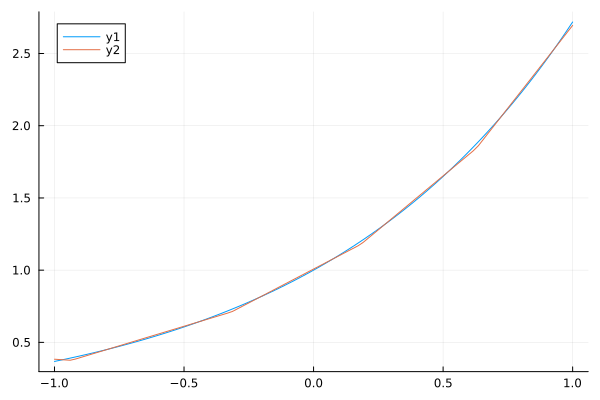

In [31]:
# TODO: Construct a model for the function and perform regression using Optimization.jl
# SOLUTION



n = 100
x = range(-1, 1; length = n)
y = exp.(x)

relu(x) = max(0,x)

# Make a function that implements the sum
function summation_model(x, 𝐚𝐛)
    n = length(𝐚𝐛) ÷ 2
    (𝐚, 𝐛) = 𝐚𝐛[1:n], 𝐚𝐛[n+1:end]
    Y = relu.(𝐚*x' .+ 𝐛)
    vec(sum(Y; dims=1)) # sums over the columns
end


# Our loss function takes in x and y as parameters
convex_regression_loss(𝐚𝐛, (x,y)) = norm(summation_model(x, 𝐚𝐛) - y)


𝐚,𝐛 = randn(n),randn(n)
prob = OptimizationProblem(OptimizationFunction(convex_regression_loss, Optimization.AutoZygote()), [𝐚;𝐛], (x,y))
@time ret = solve(prob, Adam(0.03), maxiters=1000)


using Plots
plot(x, y)
plot!(x, summation_model(x, ret.u))

# END

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*